In [3]:
import os
import zipfile
import shutil
import random
import cv2
import numpy as np

# -------------------------------
# 0. Inspection du dataset Kaggle
# -------------------------------
base_dir = '/kaggle/input/dataimage17'
print("📂 Contenu de", base_dir, ":", os.listdir(base_dir))

# Détecte automatiquement un ZIP ou un dossier d'images
zip_files = [f for f in os.listdir(base_dir) if f.lower().endswith('.zip')]
folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]

# Dossier de travail pour les opérations en écriture
work_dir = '/kaggle/working'
extract_folder = os.path.join(work_dir, 'Images_children')
os.makedirs(extract_folder, exist_ok=True)

# Choix de la source
if zip_files:
    zip_path = os.path.join(base_dir, zip_files[0])
    print(f"✅ ZIP trouvé: {zip_path}")
    use_zip = True
elif folders:
    original_folder = os.path.join(base_dir, folders[0])
    print(f"✅ Dossier d'images trouvé: {original_folder}")
    use_zip = False
else:
    raise FileNotFoundError("Aucun fichier ZIP ni dossier d'images trouvé dans dataimage17")

# -------------------------------
# 1. Décompression ou copie
# -------------------------------
if use_zip:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
    # Si le ZIP contient un sous-dossier, on le prend comme source
    entries = os.listdir(extract_folder)
    source_root = os.path.join(extract_folder, entries[0]) if entries else extract_folder
    print(f"✅ Décompression terminée, source_root = {source_root}")
else:
    # Copier le dossier d'input en lecture seule vers l'espace de travail en écriture
    shutil.copytree(original_folder, extract_folder, dirs_exist_ok=True)
    source_root = extract_folder
    print(f"✅ Copie terminée, source_root = {source_root}")

# -------------------------------
# 2. Renommer les images (dossiers 4 à 11)
# -------------------------------
for folder_name in map(str, range(4, 12)):
    folder_path = os.path.join(source_root, folder_name)
    if not os.path.isdir(folder_path):
        print(f"⚠️ Dossier manquant : {folder_path}")
        continue
    counter = 1
    for filename in os.listdir(folder_path):
        src = os.path.join(folder_path, filename)
        if os.path.isfile(src):
            ext = os.path.splitext(filename)[1]
            dst = os.path.join(folder_path, f"{folder_name}_{counter}{ext}")
            os.rename(src, dst)
            counter += 1
    print(f"👍 {folder_name} → {counter-1} fichiers renommés.")

# -------------------------------
# 3. Préparer structure train/valid/test
# -------------------------------
not_talented = ['4', '5', '6', '7']
talented = ['8', '9', '10', '11']

dest_root = os.path.join(work_dir, 'data')
for split in ['train', 'valid', 'test']:
    for cls in ['talented', 'not_talented']:
        os.makedirs(os.path.join(dest_root, split, cls), exist_ok=True)

# -------------------------------
# 4. Collecte des chemins d'images
# -------------------------------
def get_paths(folders):
    paths = []
    for f in folders:
        d = os.path.join(source_root, f)
        if os.path.isdir(d):
            for fn in os.listdir(d):
                pth = os.path.join(d, fn)
                if os.path.isfile(pth):
                    paths.append(pth)
    return paths

nt_paths = get_paths(not_talented)
t_paths = get_paths(talented)
print(f"🔢 Totaux — not_talented: {len(nt_paths)} | talented: {len(t_paths)}")

# -------------------------------
# 5. Split (70/15/15)
# -------------------------------
def split(paths, train_ratio=0.7, valid_ratio=0.15):
    random.shuffle(paths)
    total = len(paths)
    i1 = int(total * train_ratio)
    i2 = i1 + int(total * valid_ratio)
    return paths[:i1], paths[i1:i2], paths[i2:]

nt_tr, nt_va, nt_te = split(nt_paths)
t_tr, t_va, t_te = split(t_paths)
print(f"▶️ Splits — NT: {len(nt_tr)}/{len(nt_va)}/{len(nt_te)} | T: {len(t_tr)}/{len(t_va)}/{len(t_te)}")

# -------------------------------
# 6. Augmentation et copie
# -------------------------------
def augment(img):
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle=np.random.uniform(-15, 15), scale=1.0)
    img2 = cv2.warpAffine(img, M, (w, h))
    return cv2.flip(img2, 1) if random.random() > 0.5 else img2

def process(image_list, dest_folder, augment_flag=False, aug_per_image=8):
    counter = 1
    for path in image_list:
        img = cv2.imread(path)
        if img is None:
            continue
        cv2.imwrite(os.path.join(dest_folder, f"{counter:04d}.jpg"), img)
        counter += 1
        if augment_flag:
            for _ in range(aug_per_image):
                img_aug = augment(img)
                cv2.imwrite(os.path.join(dest_folder, f"{counter:04d}.jpg"), img_aug)
                counter += 1

# Training avec augmentations
process(nt_tr, os.path.join(dest_root, 'train', 'not_talented'), augment_flag=True)
process(t_tr,  os.path.join(dest_root, 'train', 'talented'),     augment_flag=True)

# Validation & Test sans augmentations
for split_name, nt_list, t_list in [('valid', nt_va, t_va), ('test', nt_te, t_te)]:
    process(nt_list, os.path.join(dest_root, split_name, 'not_talented'))
    process(t_list,  os.path.join(dest_root, split_name, 'talented'))

print(f"✅ Copie et augmentation terminées dans {dest_root}")

# -------------------------------
# 7. Création de l'archive ZIP finale
# -------------------------------
shutil.make_archive(os.path.join(work_dir, 'data_augmented'), 'zip', dest_root)
print(f"🗜️ Archive créée : {os.path.join(work_dir, 'data_augmented.zip')}\n")
# L'archive apparaîtra dans l'onglet "Output" → "File"


📂 Contenu de /kaggle/input/dataimage17 : ['Images_children']
✅ Dossier d'images trouvé: /kaggle/input/dataimage17/Images_children
✅ Copie terminée, source_root = /kaggle/working/Images_children
👍 4 → 318 fichiers renommés.
👍 5 → 294 fichiers renommés.
👍 6 → 344 fichiers renommés.
👍 7 → 356 fichiers renommés.
👍 8 → 285 fichiers renommés.
👍 9 → 277 fichiers renommés.
👍 10 → 180 fichiers renommés.
👍 11 → 85 fichiers renommés.
🔢 Totaux — not_talented: 1074 | talented: 656
▶️ Splits — NT: 751/161/162 | T: 459/98/99
✅ Copie et augmentation terminées dans /kaggle/working/data
🗜️ Archive créée : /kaggle/working/data_augmented.zip



In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

# Définir les chemins vers tes répertoires
base_dir = "/kaggle/working/data"
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")
test_dir  = os.path.join(base_dir, "test")

# Paramètres
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Pour la validation et le test, on se contente de la normalisation
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

# Générateurs
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'  # binaire car deux classes
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 10890 images belonging to 2 classes.
Found 259 images belonging to 2 classes.
Found 261 images belonging to 2 classes.


In [6]:
from tensorflow.keras import layers, models

# Charger MobileNetV2 sans la couche finale, avec les poids d'ImageNet
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               include_top=False,
                                               weights='imagenet')

# Geler le modèle de base pour débuter (on pourra le dégeler plus tard pour du fine-tuning)
base_model.trainable = False

# Modifier l'architecture existante :
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.6),
    layers.Dense(1, activation='sigmoid')
])

# Compilation du modèle
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


I0000 00:00:1745617663.873006      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,587,201 (9.87 MB)

 Trainable params: 328,705 (1.25 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True)

In [8]:
EPOCHS = 15  # Tu peux augmenter ce nombre pour de meilleurs résultats

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator
)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745617700.254870     155 service.cc:148] XLA service 0x7dcdec002c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745617700.255750     155 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745617701.193065     155 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/341 ━━━━━━━━━━━━━━━━━━━━ 1:27:17 15s/step - accuracy: 0.5625 - loss: 1.0916

I0000 00:00:1745617705.286415     155 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


341/341 ━━━━━━━━━━━━━━━━━━━━ 151s 399ms/step - accuracy: 0.7281 - loss: 0.6062 - val_accuracy: 0.8185 - val_loss: 0.4009
Epoch 2/15
341/341 ━━━━━━━━━━━━━━━━━━━━ 130s 374ms/step - accuracy: 0.7934 - loss: 0.4323 - val_accuracy: 0.7954 - val_loss: 0.4136
Epoch 3/15
341/341 ━━━━━━━━━━━━━━━━━━━━ 128s 368ms/step - accuracy: 0.8202 - loss: 0.3911 - val_accuracy: 0.8108 - val_loss: 0.4002
Epoch 4/15
341/341 ━━━━━━━━━━━━━━━━━━━━ 128s 369ms/step - accuracy: 0.8131 - loss: 0.4060 - val_accuracy: 0.8185 - val_loss: 0.3776
Epoch 5/15
341/341 ━━━━━━━━━━━━━━━━━━━━ 129s 370ms/step - accuracy: 0.8260 - loss: 0.3809 - val_accuracy: 0.8263 - val_loss: 0.3779
Epoch 6/15
341/341 ━━━━━━━━━━━━━━━━━━━━ 129s 369ms/step - accuracy: 0.8235 - loss: 0.3823 - val_accuracy: 0.8185 - val_loss: 0.3695
Epoch 7/15
341/341 ━━━━━━━━━━━━━━━━━━━━ 129s 371ms/step - accuracy: 0.8165 - loss: 0.3833 - val_accuracy: 0.8147 - val_loss: 0.3759
Epoch 8/15
341/341 ━━━━━━━━━━━━━━━━━━━━ 129s 369ms/step - accuracy: 0.8299 - loss: 0.37

In [9]:
# Définir à partir de quelle couche on souhaite dégeler (par exemple, à partir de la couche 100)
fine_tune_at = 100

# Dégeler les couches à partir de "fine_tune_at" de la base_model
for layer in base_model.layers:
    if layer.name.startswith('block'):
        print(layer.name)

# Débloquer progressivement les dernières couches
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ])
# Define INITIAL_EPOCHS using the value of EPOCHS from the initial training
INITIAL_EPOCHS = EPOCHS

# Define FINE_TUNE_EPOCHS - the number of epochs for fine-tuning
FINE_TUNE_EPOCHS = 10  # You can adjust this value

total_epochs = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1,  # Use history from initial training
    validation_data=valid_generator
)

block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_expand_BN
block_6_expand_relu
block_6_pad
block_6_depthwise
block_6_depthwise_BN
block_6_depthwise_relu
block_6_project
block_6_project_BN
block_7_expand
block_7_expan

E0000 00:00:1745619818.765902     155 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745619818.963160     155 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 93/341 ━━━━━━━━━━━━━━━━━━━━ 1:32 375ms/step - accuracy: 0.7706 - loss: 0.5582 - precision: 0.6964 - recall: 0.6651

E0000 00:00:1745619858.914753     155 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745619859.110739     155 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


341/341 ━━━━━━━━━━━━━━━━━━━━ 156s 399ms/step - accuracy: 0.8013 - loss: 0.4645 - precision: 0.7537 - recall: 0.6980 - val_accuracy: 0.8301 - val_loss: 0.6844 - val_precision: 0.8462 - val_recall: 0.6735
Epoch 17/25
341/341 ━━━━━━━━━━━━━━━━━━━━ 131s 375ms/step - accuracy: 0.8910 - loss: 0.2658 - precision: 0.8788 - recall: 0.8295 - val_accuracy: 0.7799 - val_loss: 1.1255 - val_precision: 0.9362 - val_recall: 0.4490
Epoch 18/25
341/341 ━━━━━━━━━━━━━━━━━━━━ 130s 373ms/step - accuracy: 0.9148 - loss: 0.2213 - precision: 0.8960 - recall: 0.8770 - val_accuracy: 0.7104 - val_loss: 0.8425 - val_precision: 0.5714 - val_recall: 0.9388
Epoch 19/25
341/341 ━━━━━━━━━━━━━━━━━━━━ 133s 382ms/step - accuracy: 0.9375 - loss: 0.1661 - precision: 0.9285 - recall: 0.9073 - val_accuracy: 0.8764 - val_loss: 0.4567 - val_precision: 0.8300 - val_recall: 0.8469
Epoch 20/25
341/341 ━━━━━━━━━━━━━━━━━━━━ 130s 373ms/step - accuracy: 0.9398 - loss: 0.1586 - precision: 0.9307 - recall: 0.9119 - val_accuracy: 0.8301 -

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1,  # Changed history_initial to history
    validation_data=valid_generator,
    callbacks=[early_stop, reduce_lr]
)


Epoch 16/25
341/341 ━━━━━━━━━━━━━━━━━━━━ 129s 369ms/step - accuracy: 0.9673 - loss: 0.0878 - precision: 0.9592 - recall: 0.9533 - val_accuracy: 0.8726 - val_loss: 0.3393 - val_precision: 0.7928 - val_recall: 0.8980 - learning_rate: 0.0010
Epoch 17/25
341/341 ━━━━━━━━━━━━━━━━━━━━ 129s 369ms/step - accuracy: 0.9693 - loss: 0.0848 - precision: 0.9590 - recall: 0.9595 - val_accuracy: 0.8803 - val_loss: 0.6753 - val_precision: 0.7638 - val_recall: 0.9898 - learning_rate: 0.0010
Epoch 18/25
341/341 ━━━━━━━━━━━━━━━━━━━━ 129s 372ms/step - accuracy: 0.9706 - loss: 0.0824 - precision: 0.9635 - recall: 0.9596 - val_accuracy: 0.8996 - val_loss: 0.4272 - val_precision: 0.8529 - val_recall: 0.8878 - learning_rate: 0.0010
Epoch 19/25
341/341 ━━━━━━━━━━━━━━━━━━━━ 130s 372ms/step - accuracy: 0.9701 - loss: 0.0838 - precision: 0.9650 - recall: 0.9559 - val_accuracy: 0.9112 - val_loss: 0.3017 - val_precision: 0.8571 - val_recall: 0.9184 - learning_rate: 0.0010
Epoch 20/25
341/341 ━━━━━━━━━━━━━━━━━━━━ 129

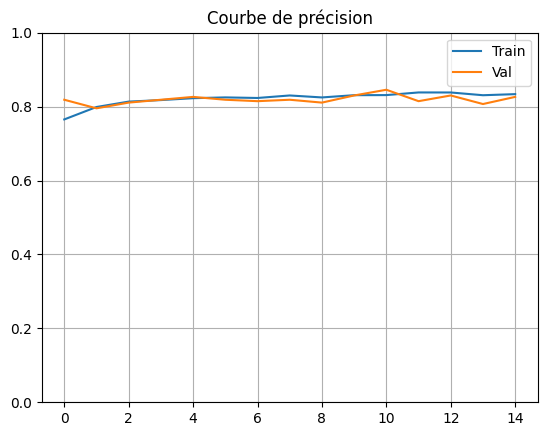

In [13]:
# Cellule 11 : Évaluation
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Val")
plt.title("Courbe de précision")
plt.legend()
plt.grid()
plt.ylim(0.0, 1.0)  # Limites de l'axe y
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 343ms/step - accuracy: 0.9157 - loss: 0.5448 - precision: 0.8479 - recall: 0.9408

📊 Résultats du test :
loss: 0.6008
compile_metrics: 0.8966


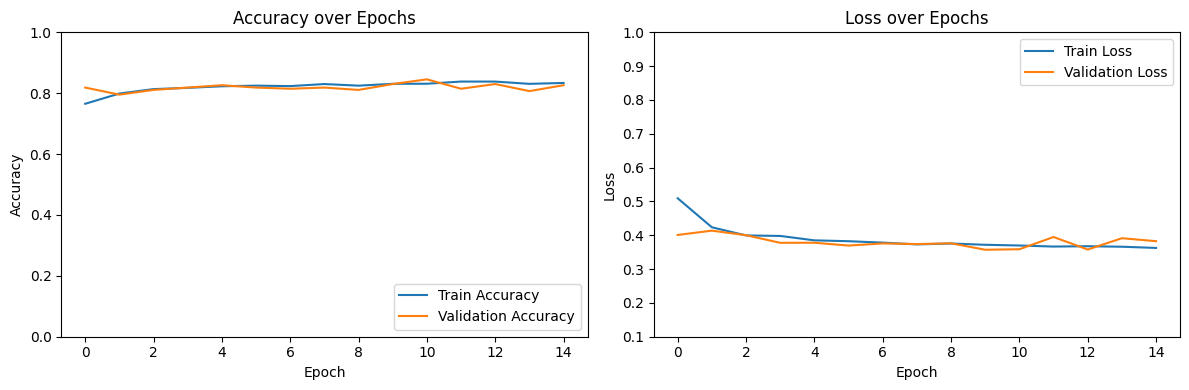

In [14]:
# ✅ Évaluation sur le jeu de test
results = model.evaluate(test_generator)

# Affichage de toutes les métriques disponibles
print("\n📊 Résultats du test :")
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

# ✅ Tracer l'évolution de la loss et de l'accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # Adapte automatiquement au nombre d'épochs

plt.figure(figsize=(12, 4))

# Courbe d'accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.0, 1.0)  # 🔧 Limite Y de 0.5 à 1
plt.legend(loc='lower right')

# Courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.1, 1.0)  # 🔧 Limite Y de 0.5 à 1 pour la loss aussi (optionnel)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()
